In [1]:
import pandas as pd
import numpy as np
import glob
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
import os

In [2]:
import scipy as sp
from scipy import signal

def emd(x, nIMF = 3, stoplim = .001):
    """Perform empirical mode decomposition to extract 'niMF' components out of the signal 'x'."""
    
    r = x
    t = np.arange(len(r))
    imfs = np.zeros(nIMF,dtype=object)
    for i in range(nIMF):
        r_t = r
        is_imf = False
        
        while is_imf == False:
            # Identify peaks and troughs
            pks = sp.signal.argrelmax(r_t)[0]
            trs = sp.signal.argrelmin(r_t)[0]
            
            # Interpolate extrema
            pks_r = r_t[pks]
            fip = sp.interpolate.InterpolatedUnivariateSpline(pks,pks_r,k=3)
            pks_t = fip(t)
            
            trs_r = r_t[trs]
            fitr = sp.interpolate.InterpolatedUnivariateSpline(trs,trs_r,k=3)
            trs_t = fitr(t)
            
            # Calculate mean
            mean_t = (pks_t + trs_t) / 2
            mean_t = _emd_complim(mean_t, pks, trs)
            
            # Assess if this is an IMF (only look in time between peaks and troughs)
            sdk = _emd_comperror(r_t, mean_t, pks, trs)
            
            # if not imf, update r_t and is_imf
            if sdk < stoplim:
                is_imf = True
            else:
                r_t = r_t - mean_t
                
        
        imfs[i] = r_t
        r = r - imfs[i] 
        
    return imfs


def _emd_comperror(h, mean, pks, trs):
    """Calculate the normalized error of the current component"""
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    return np.sum(np.abs(mean[samp_start:samp_end]**2)) / np.sum(np.abs(h[samp_start:samp_end]**2))


def _emd_complim(mean_t, pks, trs):
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    mean_t[:samp_start] = mean_t[samp_start]
    mean_t[samp_end:] = mean_t[samp_end]
    return mean_t

In [3]:
'''
df = pd.read_csv(r'C:\Program Files (x86)\Helios\Data\3_Rishiraj\SpiroData\Data_12_Jul_2021-17_06_20.csv')
#perform unity scaling
#https://datascience.stackexchange.com/questions/5885/how-to-scale-an-array-of-signed-integers-to-range-from-0-to-1
df['SVC_PRE:'] = (df['SVC_PRE:']-df['SVC_PRE:'].min())/(df['SVC_PRE:'].max()-df['SVC_PRE:'].min())
fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(np.linspace(0,60,len(df.index)), df['SVC_PRE:'])
''';

''

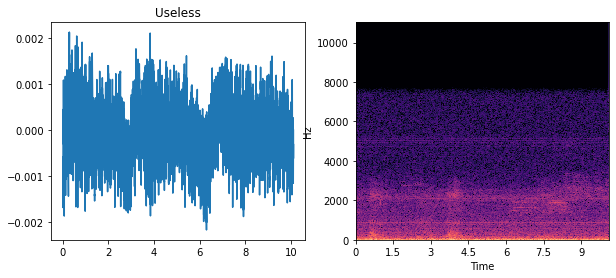

In [4]:
#read the corresponding audio file
fig,ax  = plt.subplots(1,2, figsize=(10,4))
paths = glob.glob('data/*')
nameID = 'Useless'


for file in paths:
    if os.path.basename(file).split('.')[0] == nameID:
        y, sr = librosa.load(file)
        D = librosa.stft(y)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        ax[0].plot([s/sr for s in range(0,len(y))], y)
        ax[0].set_title(os.path.basename(file).split('.')[0])
        img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax[1]);
'''
for i in range(len(imfs)):
    ax[i].plot([s/sr for s in range(0,len(y))],y,color='0.6')
    ax[i].plot([s/sr for s in range(0,len(y))],imfs[i],'k')
    ax[i].set_ylabel('IMF '+np.str(i+1))
    if i == len(imfs)-1:
        plt.xlabel('Time (s)')
'''
;

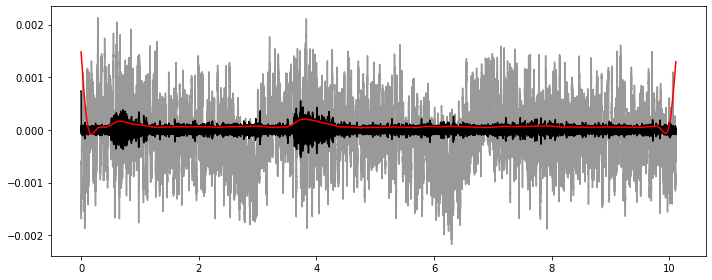

In [12]:
imfs = emd(y, nIMF = 8)
#we decided to plot IMF 3 only
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot([s/sr for s in range(0,len(y))],y,color='0.6')
ax.plot([s/sr for s in range(0,len(y))],imfs[3],'k')

#apply hilbert transform
fs = 16000
x_filt_hilbert = signal.hilbert(imfs[3])
envelope_hat = np.abs(x_filt_hilbert)
#filter the Hilbert envelope
nyq_rate = fs /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
ax.plot([s/sr for s in range(0,len(y))],envelope_hat_filt,'r')
fig.tight_layout();

## FVC From RMS Helios

<AxesSubplot:>

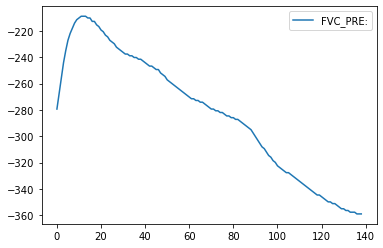

In [2]:
df = pd.read_csv(r'C:\Program Files (x86)\Helios\Data\3_Rishiraj\SpiroData\Data_10_Jul_2021-14_52_53-FVC.csv')
df.plot()

<AxesSubplot:>

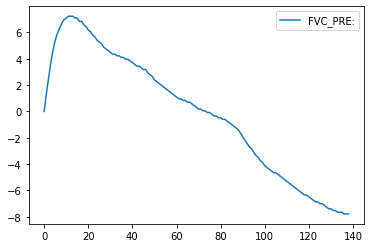

In [80]:
df.plot()

In [2]:
df = pd.read_csv(r'C:\Program Files (x86)\Helios\Data\4_Nipun Batra\SpiroData\Data_10_Jul_2021-15_02_58-FVC.csv')
df

,FVC_PRE:
0,-326.3270
1,-319.8004
2,-310.6633
3,-300.2208
4,-291.0836
...,...
180,-356.3491
181,-356.3491
182,-357.6544
183,-357.6544


<AxesSubplot:>

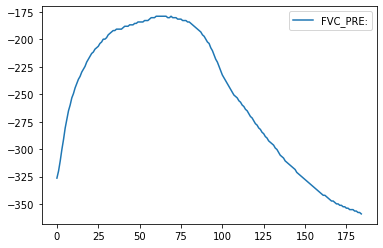

In [95]:
df.plot()

In [87]:
df['FVC_PRE:'] = ((df['FVC_PRE:'] - df.iloc[0].item())/10)+0.1813400000000005

df['FVC_PRE:'][0] = 0

<AxesSubplot:>

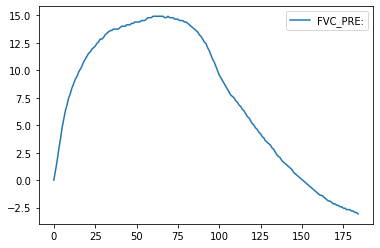

In [84]:
df.plot()

In [88]:
df

,FVC_PRE:
0,0.00000
1,0.83400
2,1.74771
3,2.79196
4,3.70568
...,...
180,-2.82087
181,-2.82087
182,-2.95140
183,-2.95140
